# Feature Importance/Coefficients

In [1]:
from pathlib import Path
import re, joblib, numpy as np, pandas as pd
import matplotlib.pyplot as plt
OUT_DIR = "/Users/cyang/src/polymer_output"
from run import suff_to_features

MODEL_SUFF = 'features_3_8'
FEATURE_COLS = suff_to_features(MODEL_SUFF)
imp_by_model = {}
MODELS = [
    "linreg", 
    "ridge", 
    # "lgbm"
    # "lasso", 
    # "elasticnet", 
    # "rf", 
]


def _model_key(stem: str) -> str:
    # e.g., "split3_lgbm_ab12cd" -> "lgbm"
    m = re.match(r"split\d+_(.+?)(?:_[0-9a-f]{6})?$", stem)
    return m.group(1) if m else stem

# imp_by_model = {}

for f in sorted((Path(OUT_DIR) / MODEL_SUFF / "models").glob("split*_*.joblib")):
    key = _model_key(f.stem)
    split_index = int(re.match(r"split(\d+)_", f.stem).group(1))
    if key not in MODELS:
        continue

    print('processing', f)

    pipe = joblib.load(f)
    est = pipe.named_steps["est"]

    if hasattr(est, "coef_"):
        imp = np.abs(np.ravel(est.coef_))
    elif hasattr(est, "alphas"):
        imp = np.abs(np.ravel(est.coef_))
    elif hasattr(est, "feature_importances_"):
        imp = np.ravel(est.feature_importances_)
    elif hasattr(est, "regressor_"):
        enet = est.regressor_
        imp = np.ravel(enet.coef_)# coefficients (for the transformed y)

    else:
        continue

    # keep only the original features (drop any imputer indicators if present)
    imp = imp[:len(FEATURE_COLS)]
    if len(imp) != len(FEATURE_COLS):
        continue  # skip if shape mismatch
    
    imp_by_model.setdefault(key, []).append([split_index] + list(imp))



processing /Users/cyang/src/polymer_output/features_3_8/models/split10_linreg.joblib
processing /Users/cyang/src/polymer_output/features_3_8/models/split10_ridge.joblib
processing /Users/cyang/src/polymer_output/features_3_8/models/split11_linreg.joblib
processing /Users/cyang/src/polymer_output/features_3_8/models/split11_ridge.joblib
processing /Users/cyang/src/polymer_output/features_3_8/models/split1_linreg.joblib
processing /Users/cyang/src/polymer_output/features_3_8/models/split1_ridge.joblib
processing /Users/cyang/src/polymer_output/features_3_8/models/split2_linreg.joblib
processing /Users/cyang/src/polymer_output/features_3_8/models/split2_ridge.joblib
processing /Users/cyang/src/polymer_output/features_3_8/models/split3_linreg.joblib
processing /Users/cyang/src/polymer_output/features_3_8/models/split3_ridge.joblib
processing /Users/cyang/src/polymer_output/features_3_8/models/split4_linreg.joblib
processing /Users/cyang/src/polymer_output/features_3_8/models/split4_ridge.j

## Avg

,linreg,ridge
feature3,-0.004324,-0.004313
feature8,0.005530,0.005515


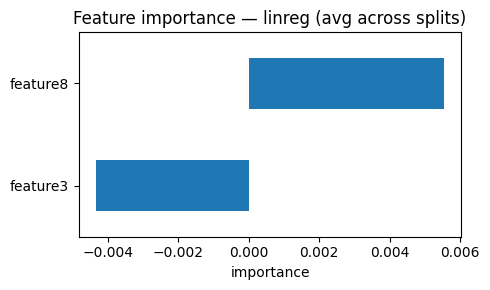

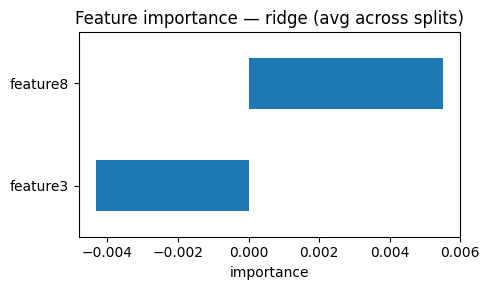

In [51]:

imp_avg = {k: np.mean(v, axis=0)[1:] for k, v in imp_by_model.items()}

imp_df = pd.DataFrame(imp_avg, index=FEATURE_COLS).fillna(0.0)

display(imp_df.sort_index())

# Plot top features for each model
TOPN = 10
for k in imp_df.columns:
    ax = imp_df[k].sort_values(ascending=False).head(TOPN).plot(kind="barh", figsize=(5, 3))
    ax.invert_yaxis()
    ax.set_title(f"Feature importance — {k} (avg across splits)")
    ax.set_xlabel("importance")
    ax.set_ylabel("")
    plt.tight_layout()
    plt.show()


## Along splits

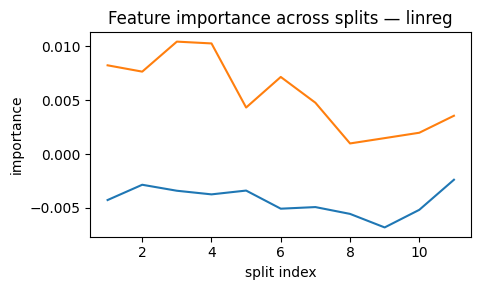

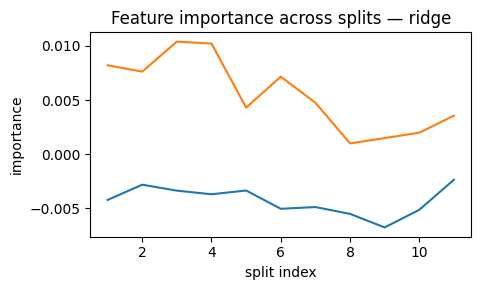

In [ ]:
for k, imps in imp_by_model.items():
    imps = np.array(imps)
    if imps.shape[1] != len(FEATURE_COLS) + 1:
        continue
    df = pd.DataFrame(imps[:, 1:], index=imps[:, 0], columns=FEATURE_COLS)
    df.sort_index(inplace=True)
    ax = df.plot(figsize=(5, 3), legend=False)
    ax.set_title(f"Feature importance across splits — {k}")
    ax.set_xlabel("split index")
    ax.set_ylabel("importance")
    plt.tight_layout()
    plt.show()

In [4]:
from joblib import load
OUT_DIR = "/Users/cyang/src/polymer_output"
m = load(f"{OUT_DIR}/models/split3_lgbm.joblib")
er = getattr(m.named_steps["est"], "evals_result_", None)
# er looks like: {'training': {'rmse': [...]}, 'valid_0': {'rmse': [...]}}
pd.DataFrame({"rmse": er["valid_0"]["rmse"]}).plot()


KeyError: 'valid_0'

In [5]:
er

{}

In [8]:

import lightgbm as lgb


In [17]:
pipe = load(f"{OUT_DIR}/models/split10_elasticnet.joblib")
est = pipe.named_steps["est"]
try:
    # if you used TransformedTargetRegressor (Option A)
    enet = est.regressor_
except AttributeError:
    enet = est

print("alpha_* =", enet.alpha_, " grid[min,max] =", enet.alphas_.min(), enet.alphas_.max())
print("nonzero betas =", (enet.coef_[:len(FEATURE_COLS)] != 0).sum())

# load json


alpha_* = 0.01  grid[min,max] = 1e-06 0.01
nonzero betas = 0


In [16]:

df = pd.read_parquet("/Users/cyang/src/polymer/data_clipped_no_na.parquet", engine="fastparquet")

split_joson_fn = '/Users/cyang/src/polymer_output/features_8_7_10/splits/11_splits/split_10.json'
import json
with open(split_joson_fn) as f:
    split_info = json.load(f)
    tr_idx =  np.fromstring(split_info["train_idx"].strip("[]"), sep=" ", dtype=int)
    y_tr = df.loc[tr_idx, 'target'].to_numpy()
    print("y_train std =", y_tr.std())

y_train std = 0.004183428085574576


/var/folders/_k/9145302s6s53fylr_cs9f17c0000gn/T/ipykernel_33611/2014312654.py:7: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  tr_idx =  np.fromstring(split_info["train_idx"].strip("[]"), sep=" ", dtype=int)


In [19]:
pipe = load(f"/Users/cyang/src/polymer_output/all/models/split10_elasticnet.joblib")

ttr = pipe.named_steps["est"]                 # the TransformedTargetRegressor
y_mean = float(ttr.transformer_.mean_[0])     # train-set mean of y
y_std  = float(ttr.transformer_.scale_[0])    # train-set std of y (population std)
n_seen = int(ttr.transformer_.n_samples_seen_)
print(y_mean, y_std, n_seen)


0.0006617259607946488 0.03061441321188568 492332
